<a href="https://colab.research.google.com/github/jungmin0710/K-digital-PythonDeepLearning/blob/main/Vanilla_GAN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla GAN(Generative Adversarial Network)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 0.Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU

## 1.Load MNIST Dataset
* 'generator'의 'tanh' Activation 출력에 적합하도록 정규화


In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Normalization : tanh함수를 사용(-1~1)하기 때문에 사잇값이 되도록 225의 반으로 나눈 후, -1을 해준다
X_train = X_train.astype(np.float32) / 127.5 - 1

#Reshape
X_train = X_train.reshape(60000, 784)

11493376/11490434 [==============================] - 0s 0us/step


## 2.'adam' Optimizer
* beta_1 : 감쇠율 조정

In [5]:
from keras.optimizers import Adam

adam = Adam(lr = 0.0002, beta_1 = 0.5)


## 3.'generator' Model
* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
  * NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
  * 'Real Image'와 같은 'Fake Image' 생성이 목적

In [6]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

#노이즈 데이터 입력받아서 fake 결과물을 만들어 내는 모델 레이어 쌓기
generator.add(Dense(256, input_shape = (NOISE_DIM, )))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh'))


* Model Summary

In [7]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2816      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               80

## 4.'discriminator' Model
* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image'인지 판별
  * 이진분류

In [8]:
from tensorflow.keras.initializers import RandomNormal

#Fake인지 Real인지 판단하는 이진분류를 수행함
discriminator = Sequential(name = 'discriminator')

discriminator.add(Dense(1024,
                        input_shape = (784,),
                        kernel_initializer = RandomNormal(stddev = 0.02)))

discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [9]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)             

### 1)'discriminator' Compile
* 학습 설정

In [10]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = adam)

## 5. 'gan' Model

### 1)'generator','discriminator' 연결
* 'gan'모델에서 'generator'만 학습하도록 설정
  * discriminator.trainable = False

In [11]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

### 2)'gan' Model




In [12]:
gan = Model(gan_input, output, name = 'gan')

### 3)'gan' Summary

In [14]:
gan.summary()

Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
generator (Sequential)       (None, 784)               1463312   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


### 4)'gan' Compile
* 학습 설정

In [15]:
gan.compile(loss = 'binary_crossentropy',
            optimizer = adam)

## 6.Define 'get_batches()' Function
* MNIST image batch 생성

In [16]:
def get_batches(data, batch_size):
  batches = []

  for i in range(data.shape[0] // batch_size):
    batch = data[i * batch_size : (i + 1) * batch_size]
    batches.append(batch)
  return np.asarray(batches)

## 7.'visualize_training()' Function

In [17]:
def visualize_training(epoch, d_losses, g_losses): 
  # 오차 시각화
  # plt.figure(figsize=(8, 4))
  # plt.plot(d_losses, label='Discriminator Loss') 
  # plt.plot(g_losses, label='Generatror Loss') 
  # plt.xlabel('Epoch') # plt.ylabel('Loss') 
  # plt.legend() # plt.show()
  # print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_loss)
  
  # 이미지 생성 결과 시각화 
  print('epoch :', epoch) 
  noise = np.random.normal(0, 1, size = (24, NOISE_DIM)) 
  generated_images = generator.predict(noise) 
  generated_images = generated_images.reshape(-1, 28, 28)

  plt.figure(figsize = (8, 4)) 
  
  for i in range(generated_images.shape[0]): 
    plt.subplot(4, 6, i + 1)
    plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r') 
    plt.axis('off') 
  plt.tight_layout() 
  plt.show()

## 8.Model Training
* 약 35분 
* fit()
  * 'epoch', 'batch_size' 지정
* train_on_batch()
  * 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 'train_on_batch()' 사용

epoch : 1


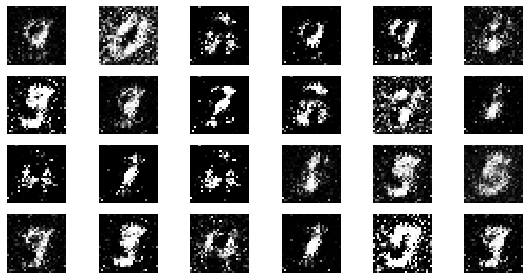

epoch : 5


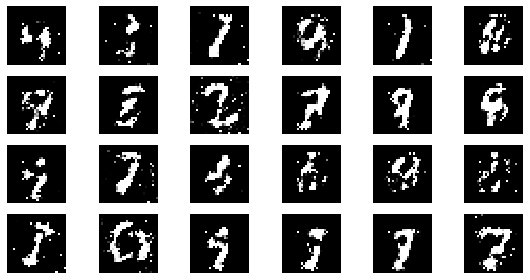

epoch : 10


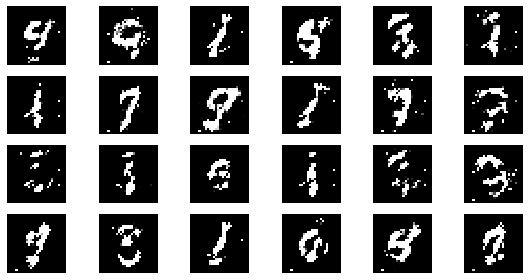

epoch : 15


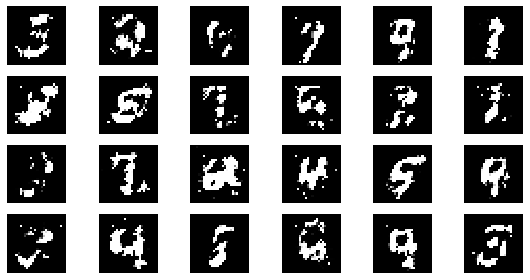

epoch : 20


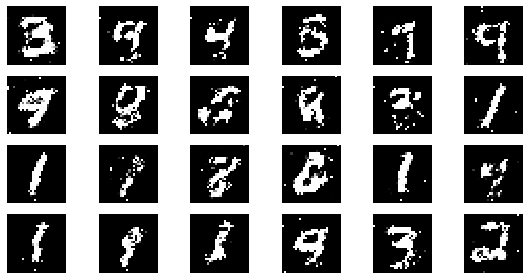

epoch : 25


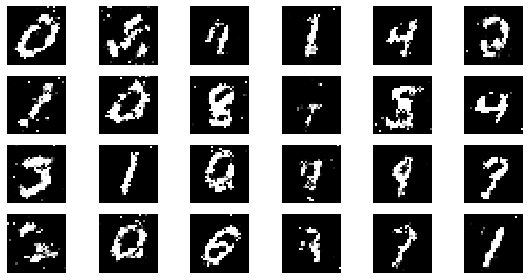

epoch : 30


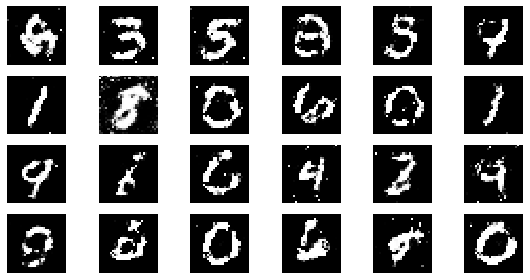

epoch : 35


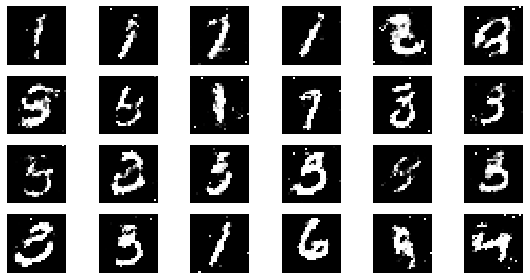

epoch : 40


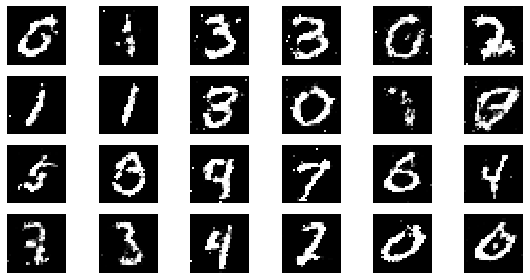

epoch : 45


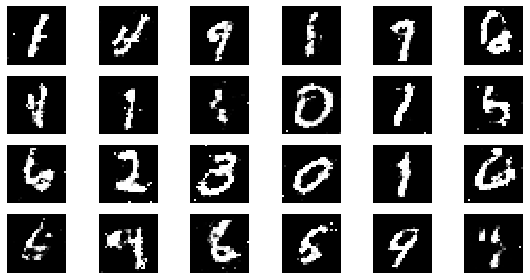

epoch : 50


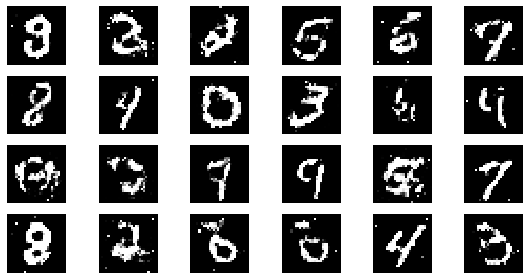

epoch : 55


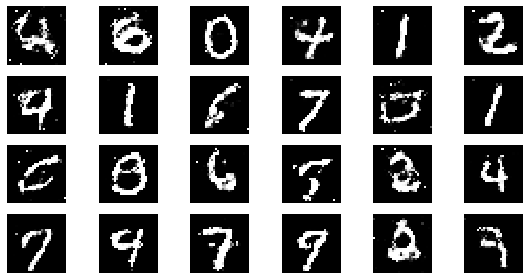

epoch : 60


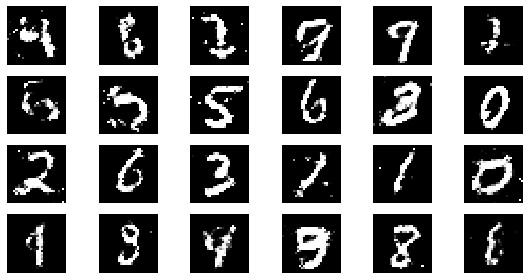

epoch : 65


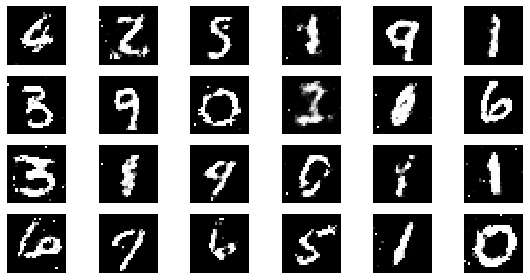

epoch : 70


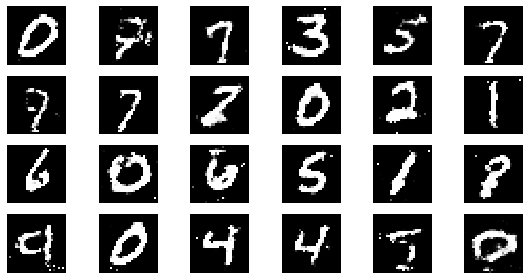

epoch : 75


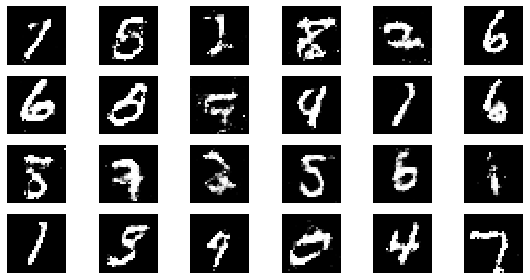

epoch : 80


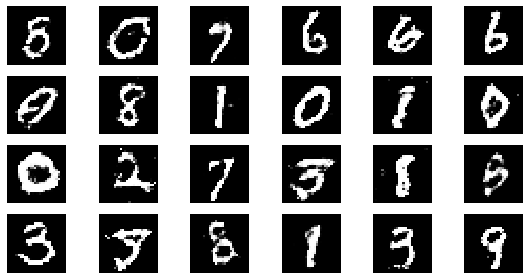

epoch : 85


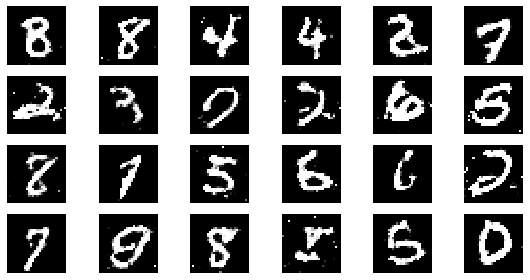

epoch : 90


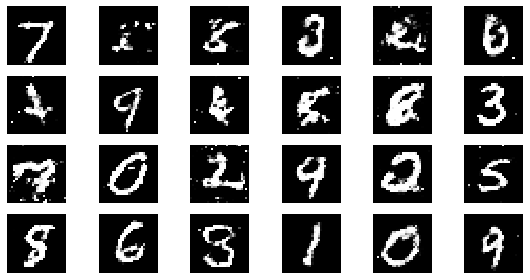

epoch : 95


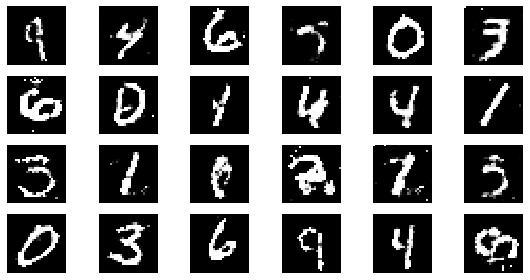

epoch : 100


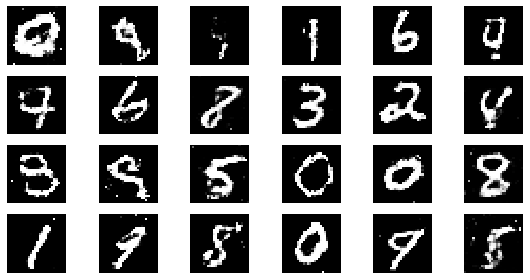

CPU times: user 33min 22s, sys: 1min 43s, total: 35min 6s
Wall time: 33min 41s


In [19]:
%%time

EPOCHS = 100 
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List 
d_losses = [] 
g_losses = []

for epoch in range(1, EPOCHS + 1): 
  # batch 별 학습 
  for real_images in get_batches(X_train, BATCH_SIZE): 
    # Random Noise 생성
    input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM]) 
    
    # Fake Image 데이터 생성
    generated_images = generator.predict(input_noise) 
    
    # 'gan' 학습용 X 데이터 정의
    x_dis = np.concatenate([real_images, generated_images])

    # 'gan' 학습용 y 데이터 정의 
    y_dis = np.zeros(2 * BATCH_SIZE) 
    y_dis[:BATCH_SIZE] = 1
    
    # 'discriminator' 학습 
    discriminator.trainable = True 
    d_loss = discriminator.train_on_batch(x_dis, y_dis)

    # 'gan' 학습
    noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM]) 
    y_gan = np.ones(BATCH_SIZE)

    # 'discriminator' 학습 정지 
    discriminator.trainable = False 
    g_loss = gan.train_on_batch(noise, y_gan)

  d_losses.append(d_loss) 
  g_losses.append(g_loss)
  
  # 생성 결과 시각화 : epoch 5번마다 결과 출력 # 생성 결과 시각화 : epoch 5번마다 결과 출력
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)
  if epoch == 1 or epoch % 5 == 0:
    visualize_training(epoch, d_losses, g_losses)

본 내용은 2021/03/30(화)에 학습한 내용입니다.